<a href="https://colab.research.google.com/github/ESBL01/2025_AI/blob/main/CIFAR_10_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=False)

def evaluate(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in testloader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            _, predicted = torch.max(outputs, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    return 100 * correct / total


100%|██████████| 170M/170M [00:01<00:00, 94.4MB/s]


In [2]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

model_cnn = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

cnn_acc = []
for epoch in range(10):
    model_cnn.train()
    for x, y in trainloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(model_cnn(x), y)
        loss.backward()
        optimizer.step()
    acc = evaluate(model_cnn)
    cnn_acc.append(acc)
    print(f"SimpleCNN Epoch {epoch+1}: {acc:.2f}%")


SimpleCNN Epoch 1: 47.70%
SimpleCNN Epoch 2: 52.47%
SimpleCNN Epoch 3: 56.61%
SimpleCNN Epoch 4: 56.02%
SimpleCNN Epoch 5: 57.96%
SimpleCNN Epoch 6: 57.15%
SimpleCNN Epoch 7: 57.17%
SimpleCNN Epoch 8: 57.01%
SimpleCNN Epoch 9: 55.77%
SimpleCNN Epoch 10: 56.93%


In [3]:
from torchvision.models import resnet18

model_resnet = resnet18(weights=None)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, 10)
model_resnet = model_resnet.to(device)

optimizer = optim.Adam(model_resnet.parameters(), lr=0.001)
resnet_acc = []
for epoch in range(10):
    model_resnet.train()
    for x, y in trainloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(model_resnet(x), y)
        loss.backward()
        optimizer.step()
    acc = evaluate(model_resnet)
    resnet_acc.append(acc)
    print(f"ResNet18 Epoch {epoch+1}: {acc:.2f}%")


ResNet18 Epoch 1: 54.15%
ResNet18 Epoch 2: 66.42%
ResNet18 Epoch 3: 75.06%
ResNet18 Epoch 4: 74.92%
ResNet18 Epoch 5: 79.89%
ResNet18 Epoch 6: 73.62%
ResNet18 Epoch 7: 82.34%
ResNet18 Epoch 8: 80.42%
ResNet18 Epoch 9: 82.41%
ResNet18 Epoch 10: 82.14%


In [5]:
from torchvision.models import efficientnet_b0

model_eff = efficientnet_b0(weights=None)
model_eff.classifier[1] = nn.Linear(model_eff.classifier[1].in_features, 10)
model_eff = model_eff.to(device)

optimizer = optim.Adam(model_eff.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

effnet_acc = []
for epoch in range(10):
    model_eff.train()
    for x, y in trainloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(model_eff(x), y)
        loss.backward()
        optimizer.step()

    acc = evaluate(model_eff)
    effnet_acc.append(acc)
    print(f"EfficientNet Epoch {epoch+1}: {acc:.2f}%")


EfficientNet Epoch 1: 61.02%
EfficientNet Epoch 2: 73.17%
EfficientNet Epoch 3: 78.52%
EfficientNet Epoch 4: 82.61%
EfficientNet Epoch 5: 84.21%
EfficientNet Epoch 6: 84.40%
EfficientNet Epoch 7: 85.74%
EfficientNet Epoch 8: 84.83%
EfficientNet Epoch 9: 86.47%
EfficientNet Epoch 10: 86.78%


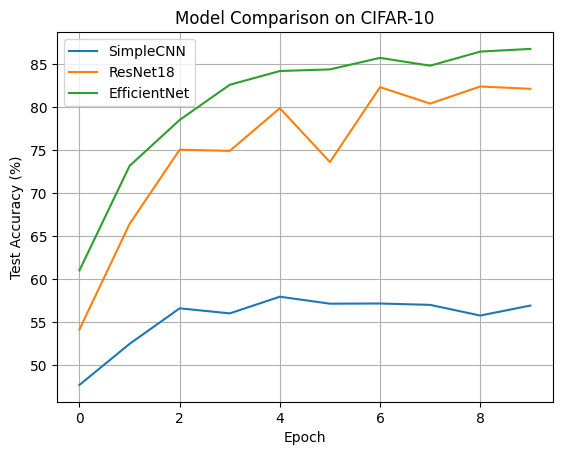

In [6]:
plt.plot(cnn_acc, label="SimpleCNN")
plt.plot(resnet_acc, label="ResNet18")
plt.plot(effnet_acc, label="EfficientNet")
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")
plt.title("Model Comparison on CIFAR-10")
plt.legend()
plt.grid(True)
plt.show()
